In [ ]:
#Librerias a utilizar 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import librosa
import librosa.display
import pandas as pd
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import scipy
import sys
import pickle
%matplotlib inline
import os
import pathlib
import csv
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import IPython.display as ipd

In [ ]:
#Cargo los archivos desde mi drive 
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
#Se carga el segundo archivo del dataset 
archivo2=pd.read_csv('/drive/MyDrive/Inteligencia_Artificial/Dataset/features_3_sec.csv')
archivo2=archivo2.iloc[0:, 1:]
archivo2.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
#Informacion del conjunto de datos para conocer mejor los datos que se manejaran 
archivo2.shape
archivo2.dtypes

length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var                  float64
mfcc6_mean          

In [6]:
#Revision de archivos de audio
#Se puede cargar cualquiera de los archivos de audio del dataset para conocer el tipo
audio_recording='/drive/MyDrive/Inteligencia_Artificial/Dataset//genres_original/reggae/reggae.00057.wav'
Dataset, sr = librosa.load(audio_recording) # sr es la frecuencia de muestreo 
print(type(Dataset), type(sr))
print('La frecuencia de muestreo es:', sr)

<class 'numpy.ndarray'> <class 'int'>
La frecuencia de muestreo es: 22050


In [7]:
#Reproduccion el archivo de audio seleccionado
import IPython 
IPython.display.Audio(Dataset, rate=sr)

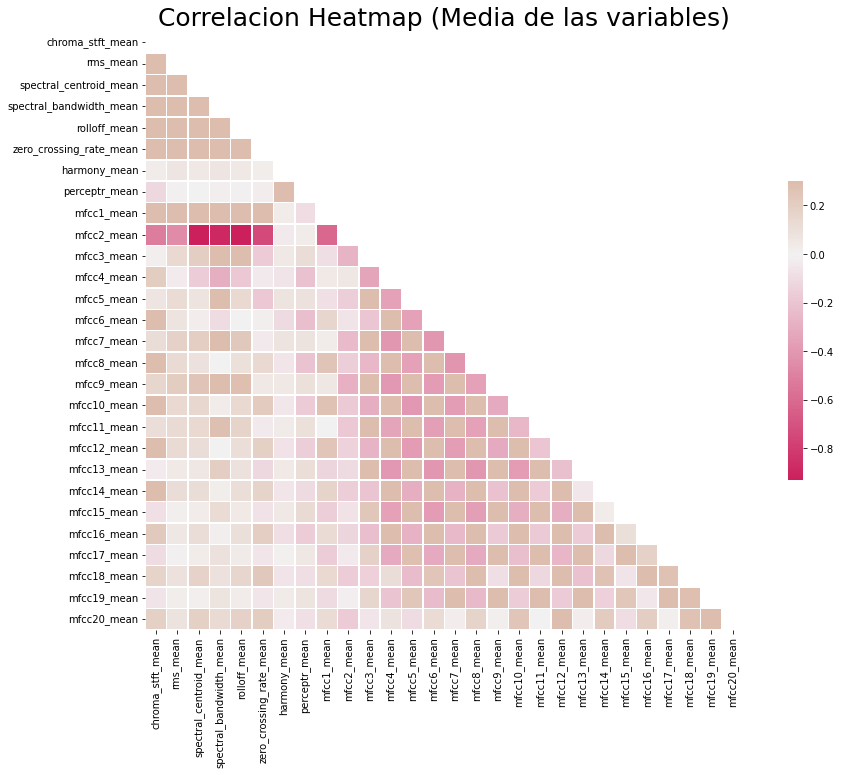

In [8]:
# Primero se realizara correlation heatmap para hallar la media de caracteristicas
#Primero se calcula la matriz de correlacion 
spike_cols = [col for col in archivo2.columns if 'mean' in col]
corr = archivo2[spike_cols].corr()
#Se genera una mascara
mask = np.triu(np.ones_like(corr, dtype=np.bool))
#Grafica
f, ax = plt.subplots(figsize=(16, 11)); #Configuracion para la grafica
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5) #Mapa de color 
#Se grafica el heatmap con la mascara y la relacion 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlacion Heatmap (Media de las variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);


Text(0, 0.5, 'BPM')

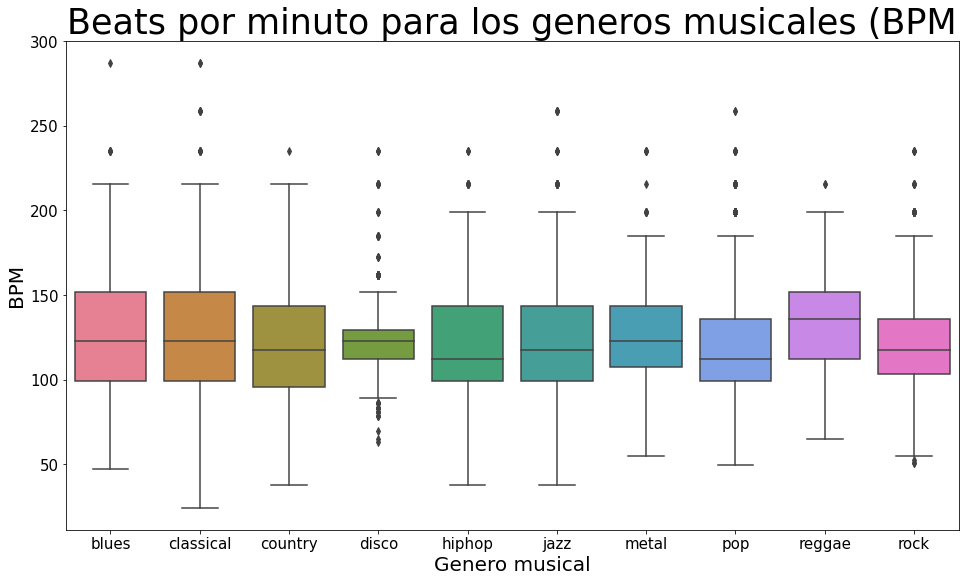

In [9]:
# Se realizara un Box Plot para distribuir los generos musicales por tiempo de beats
x = archivo2[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('Beats por minuto para los generos musicales (BPM', fontsize = 35)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);
plt.xlabel("Genero musical", fontsize = 20)
plt.ylabel("BPM", fontsize = 20)

In [10]:
from sklearn import preprocessing
archivo = archivo2.iloc[0:, 1:]
y = archivo['label']
X = archivo.loc[:, archivo.columns != 'label']

In [11]:
# Ahora se normlaizaran los datos para que esten en la misma escala 
y = archivo2['label'] 
X = archivo2.loc[:, archivo2.columns != 'label'] 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

#Nuevos datos escalados 
X = pd.DataFrame(np_scaled, columns = cols)

In [12]:
#Representación y reducción dimensional 
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [13]:
# Se concatena con la etiqueta de destino 
finalDf = pd.concat([principalDf, y], axis = 1)
#Varianza explicada
pca.explained_variance_ratio_

array([0.26745621, 0.18238003])

Text(0, 0.5, 'Componente principal 2')

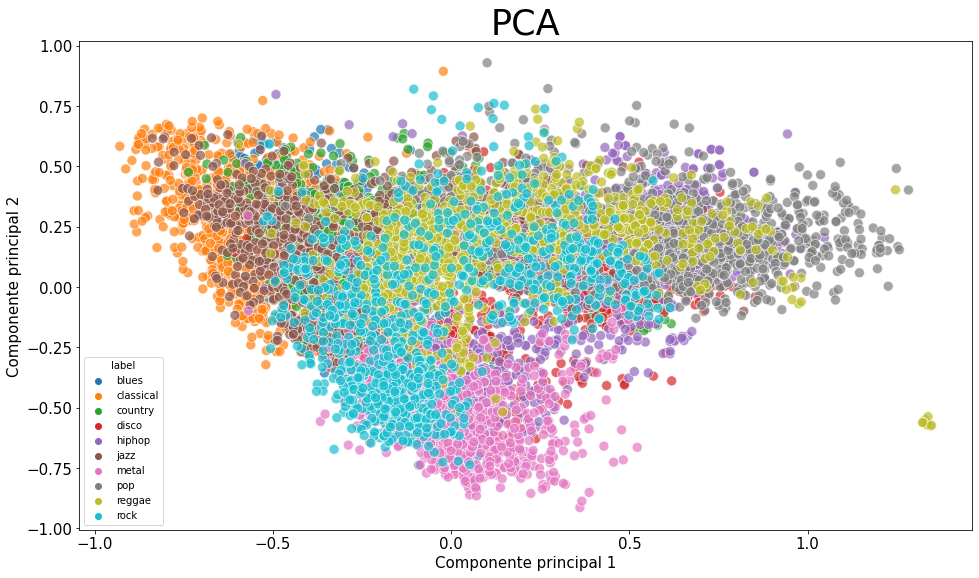

In [14]:
#Grafica 
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA', fontsize = 35)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);
plt.xlabel("Componente principal 1", fontsize = 15)
plt.ylabel("Componente principal 2", fontsize = 15)

In [15]:
#Se dividen los datos en entrenamiento y prueba 
# Se separaran 70% para entrenamiento y 30% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [17]:
#Funcion creada para probar distintos modelos y evaluar el desempeño
def modelo_general(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(title,':')
    print('Accuracy:', round(accuracy_score(y_test, preds), 5))
    print("MCC:", round(metrics.matthews_corrcoef(y_test, preds),5))
    #print("AUC-ROC:", metrics.roc_auc_score(y_test, preds,average='macro'))
    print("F1 Score:", round(metrics.f1_score(y_test, preds,average='macro'),5), '\n')

In [18]:
#Se prueban diferentes modelos de los vistos en clase para comparar el desempeño del modelo 
# y poder seleccionar el mejor 

# Naive Bayes
nb = GaussianNB()
modelo_general(nb, "Naive Bayes")

# Descenso del gradiente estocastico 
sgd = SGDClassifier(max_iter=5000, random_state=0)
modelo_general(sgd, "Descenso del gradiente estocastico")

# KNN- Vecinos mas cercanos
knn = KNeighborsClassifier(n_neighbors=30)
modelo_general(knn, "KNN-Vecinos mas cercanos")

# arbol de decision 
tree = DecisionTreeClassifier()
modelo_general(tree, "Arbol de decision")

# Random Forest- bosque aleatorio
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
modelo_general(rforest, "Random Forest")

# Maquinas de vectores de soporte 
svm = SVC(decision_function_shape="ovo")
modelo_general(svm, "Maquinas de vectores de soporte")

# Regresion Logistica 
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
modelo_general(lg, "Regresion Logistica")

# Redes neuronales
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
modelo_general(nn, "Redes neuronales")


Naive Bayes :
Accuracy: 0.51952
MCC: 0.47209
F1 Score: 0.50268 

Descenso del gradiente estocastico :
Accuracy: 0.65532
MCC: 0.62157
F1 Score: 0.63085 

KNN-Vecinos mas cercanos :
Accuracy: 0.77211
MCC: 0.74807
F1 Score: 0.77238 

Arbol de decision :
Accuracy: 0.64831
MCC: 0.60953
F1 Score: 0.64814 

Random Forest :
Accuracy: 0.81415
MCC: 0.79411
F1 Score: 0.81208 

Maquinas de vectores de soporte :
Accuracy: 0.75409
MCC: 0.72706
F1 Score: 0.75165 

Regresion Logistica :
Accuracy: 0.6977
MCC: 0.66471
F1 Score: 0.69233 

Redes neuronales :
Accuracy: 0.67167
MCC: 0.63564
F1 Score: 0.66673 



In [19]:
#De acuardo a los resultados anteriores se selecciono el mejor como Random Forest
# Para optimizar los hiperparametros se realiza variaciones en la profundidad de los arboles y la cantidad de arboles  
rforest = RandomForestClassifier(n_estimators=500, max_depth=100, random_state=0)
rforest.fit(X_train, y_train)

preds=rforest.predict(X_test)
print('Accuracy', ':', round(accuracy_score(y_test, preds), 5))
print("MCC:", metrics.matthews_corrcoef(y_test, preds))
print("F1 Score:", metrics.f1_score(y_test, preds,average='macro'), '\n')

Accuracy : 0.87788
MCC: 0.864495367148106
F1 Score: 0.8767538901498255 



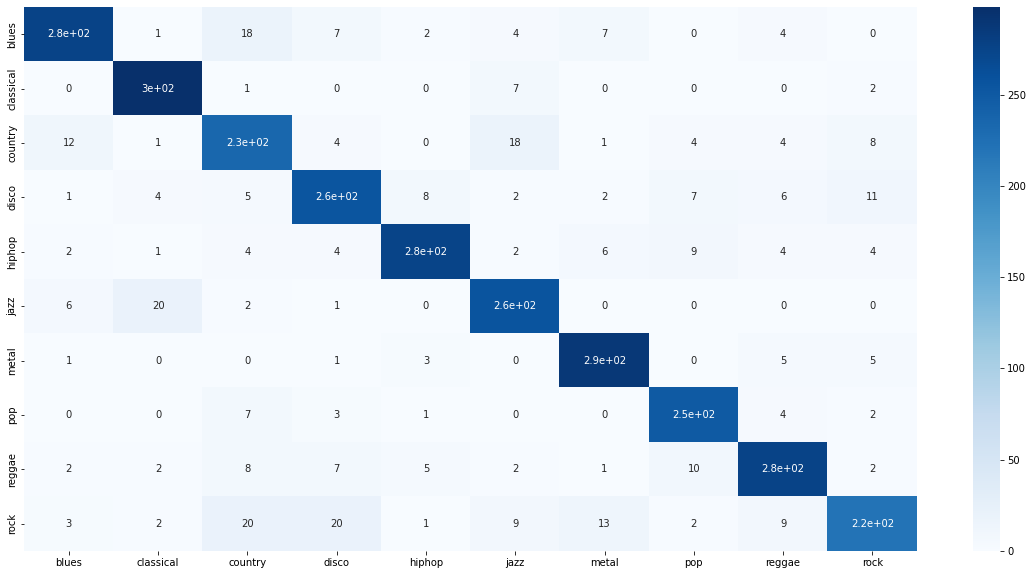

In [20]:
#Matriz de confusion 
Matriz_Confusion = confusion_matrix(y_test, preds)
#Se grafica la matriz de confusion 
plt.figure(figsize = (20, 10))
sns.heatmap(Matriz_Confusion, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
